## A. Importing necessary files and modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
from pathlib import Path
from tqdm.auto import tqdm

CWD = Path(os.getcwd())
PYFILES_PATH = CWD.parent / "PyFiles"
sys.path.append(str(PYFILES_PATH))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential

# these are in the PYFILES_PATH
from utils import *
import settings as bc
import my_neural_networks as my_nn

import pickle

2023-10-02 22:58:17.152934: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-02 22:58:17.192270: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
plt.rcParams["savefig.dpi"] = 400
plt.rcParams["font.size"] = 13
plt.rcParams["legend.frameon"] = False

## B. Visualizing the ClimateBench data

### 1. Preparing the data

In [4]:
scenarios_for_training = ["historical"] + ["ssp{}".format(x) for x in [126, 370, 585]]
scenario_for_testing = "ssp245"
total_scenarios = scenarios_for_training + [scenario_for_testing]

inputs_and_outputs = [
    [
        "/".join([bc.TRAIN_PATH[0:-1], f"{j}_{x}"])
        if x != "ssp245"
        else "/".join([bc.TEST_PATH[0:-1], f"{j}_{x}"])
        for x in total_scenarios
    ]
    for j in ["inputs", "outputs"]
]
for put in inputs_and_outputs:
    put.sort(key=lambda x: x.split("_")[-1])
inputs, outputs = inputs_and_outputs

### 2. Visualization of CO$_2$ and CH$_4$ historical and projected emissions

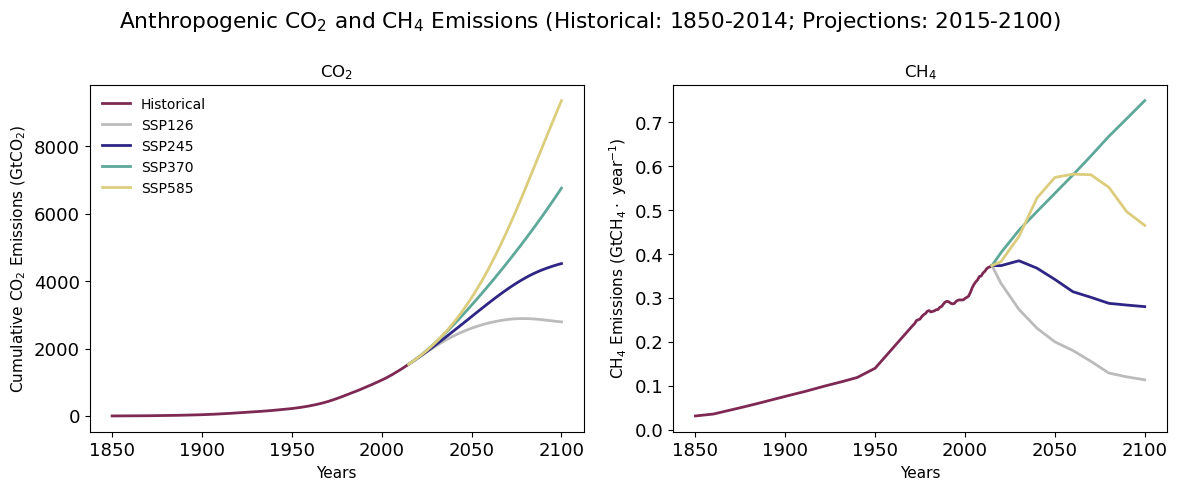

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i, inp in enumerate(inputs):
    label = inp.split("_")[-1]
    if "ssp" in label:
        label = label.replace("ssp", "SSP")
    else:
        label = "H" + label[1:]
    data = open_dataset(inp)
    x_dim = data.time.data

    for j, gas in enumerate(["CO2", "CH4"]):
        data[gas].plot(label=label, color=bc.CHLIST[i], linewidth=2, ax=ax[j])
        if j == 0:
            ax[j].set_ylabel(r"Cumulative CO$_2$ Emissions (GtCO$_2$)", fontsize=11)
            ax[j].legend(fontsize=10)
        else:
            ax[j].set_ylabel(
                r"CH$_4$ Emissions (GtCH$_4 \cdot$ year$^{-1}$)", fontsize=11
            )
        ax[j].set_xlabel("Years", fontsize=11)
        ender = r"$_2$"
        if j == 1:
            ender = r"$_4$"
        ax[j].set_title(gas[0:-1] + ender, fontsize=12)
    plt.suptitle(
        r"Anthropogenic CO$_2$ and CH$_4$ Emissions (Historical: 1850-2014; Projections: 2015-2100)",
        y=0.98,
    )
plt.tight_layout()

### 3. Visualization of global average temperature, historical and projected

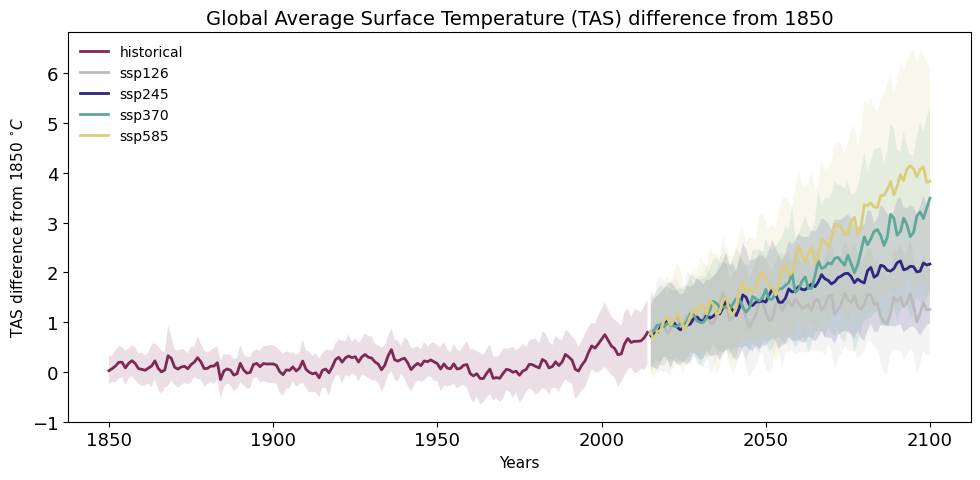

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i, outp in enumerate(outputs):
    label = outp.split("_")[-1]
    data = open_dataset(outp).mean(dim="member")[["tas"]].drop(["quantile"])
    x_dim = data.time.data

    weights = np.cos(np.deg2rad(data.lat))
    tas = data["tas"].weighted(weights)
    tas_mean, tas_std = tas.mean(["lat", "lon"]).data, tas.std(["lat", "lon"]).data

    ax.plot(x_dim, tas_mean, label=label, color=bc.CHLIST[i], linewidth=2)
    ax.fill_between(
        x_dim,
        tas_mean - tas_std,
        tas_mean + tas_std,
        facecolor=bc.CHLIST[i],
        alpha=0.15,
    )

ax.set_ylabel("TAS difference from 1850 $^{\circ}C$", fontsize=11)
ax.set_xlabel("Years", fontsize=11)
ax.set_title(
    "Global Average Surface Temperature (TAS) difference from 1850", fontsize=14
)
ax.legend(fontsize=10, loc="upper left")
plt.tight_layout()

### 4. Historical and future simulations of global average surface temperature

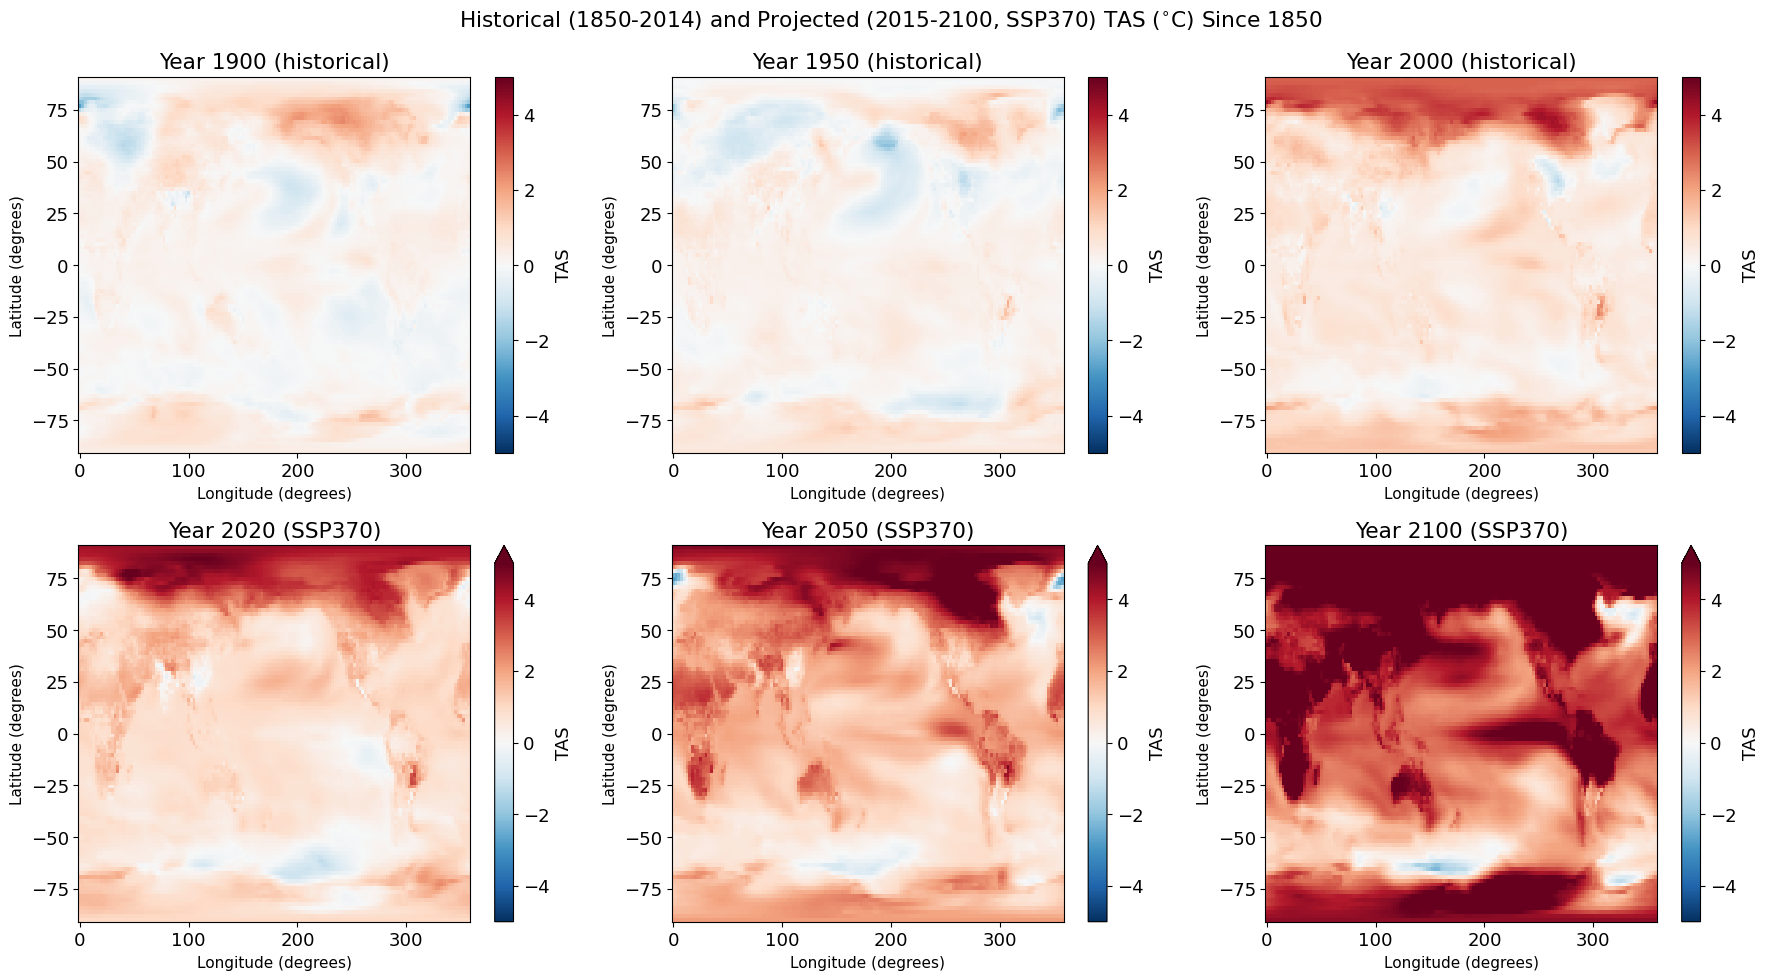

In [7]:
hist_and_ssp370 = []
for i in ["historical", "ssp370"]:
    loc = [x for x in outputs if i in x][0]
    data = open_dataset(loc).mean(dim="member")[["tas"]].drop(["quantile"])
    hist_and_ssp370.append(data)

fig, ax = plt.subplots(2, 3, figsize=(18, 10))
vmin, vmax = -5, 5
years = [1900, 1950, 2000, 2020, 2050, 2100]
for i, data in enumerate(hist_and_ssp370):
    i_yrs = years[0:3]
    data = data.rename({"tas": "TAS"})
    if i == 1:
        i_yrs = years[3:]

    for j, yr in enumerate(i_yrs):
        data.sel(time=yr).TAS.plot(
            ax=ax[i, j], vmin=vmin, vmax=vmax, cmap="RdBu_r", label=r"TAS ($^{\circ}$C)"
        )
        ax[i, j].set_ylabel("Latitude (degrees)", fontsize=11)
        ax[i, j].set_xlabel("Longitude (degrees)", fontsize=11)
        ax[i, j].set_title(f"Year {yr} (historical)")
        if i != 0:
            ax[i, j].set_title(f"Year {yr} (SSP370)")

plt.suptitle(
    r"Historical (1850-2014) and Projected (2015-2100, SSP370) TAS ($^{\circ}$C) Since 1850"
)
plt.tight_layout()

## C. Neural networks (NN) and temperature prediction, based on the time-series of CO$_2$ and CH$_4$ emissions

### 1. Data preprocessing

#### a. Importing datasets as training and test sets

- Training data: 3 future scenarios (SSP126, SSP370, SSP585) and 3 historical scenarios (`historical`, `hist-aer`, `hist-GHG`)
- Testing data: SSP245

In [8]:
# `prepare_predictor` and `prepare_predictand` are all in
# the file `utils.py`.
train_scenarios = ["historical", "ssp585", "ssp126", "ssp370", "hist-aer", "hist-GHG"]
test_scenario = "ssp245"

X_train_xr, _ = prepare_predictor(train_scenarios, bc.TRAIN_PATH)
y_train_xr, _ = prepare_predictand(train_scenarios, bc.TRAIN_PATH)

X_test_xr, _ = prepare_predictor(test_scenario, bc.TEST_PATH)
y_test_xr, _ = prepare_predictand(test_scenario, bc.TEST_PATH)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

#### b. Selection of relevant variables

We would like the following:
- predictors to be `CO2` and `CH4`
- predictand to be `tas`

The above-imported `xarray.Dataset`s are going to be turned into `pandas.DataFrame`s, after selecting appropriate variables.

In [9]:
X_train_df = pd.DataFrame(
    data={x: X_train_xr[x] for x in ["CO2", "CH4"]},
    index=X_train_xr["CO2"].coords["time"].values,
)
X_test_df = pd.DataFrame(
    data={x: X_test_xr[x] for x in ["CO2", "CH4"]},
    index=X_test_xr["CO2"].coords["time"].values,
)

# "flattening" the 2D map into a 1D map for NN implementation
y_train_df = pd.DataFrame(
    y_train_xr["tas"].stack(dim=["latitude", "longitude"]).to_pandas()
)
y_test_df = pd.DataFrame(
    y_test_xr["tas"].stack(dim=["latitude", "longitude"]).to_pandas()
)

#### c. Data normalization (by mean and standard deviation)

We conduct this for the inputs only. The said mean and standard deviation are given from `X_train_df`.

In [10]:
normalization = [X_train_df.mean(), X_train_df.std()]
X_train_df = (X_train_df - normalization[0]) / normalization[1]
X_test_df = (X_test_df - normalization[0]) / normalization[1]

X_train, X_test = X_train_df.to_numpy(), X_test_df.to_numpy()
y_train = y_train_df.to_numpy()

print(
    "The dimensions for training data (predictor) are: ({}, {})".format(
        X_train.shape[0], X_train.shape[1]
    )
)
print(
    "The dimensions for training data (predictands) are: ({}, {})".format(
        y_train.shape[0], y_train.shape[1]
    )
)

The dimensions for training data (predictor) are: (753, 2)
The dimensions for training data (predictands) are: (753, 13824)


### 2. Defining the NN structure, and fitting the models

See `my_neural_networks.py` file and the in-class Jupyter notebook (`Neural_Network_example.ipynb`) for further information. We also save the models after they are fitted.

In [11]:
input_dim, output_dim = X_train.shape[1], y_train.shape[1]

# each test case contains: (i) loss function, (ii) number of neurons,
# (iii) hidden layer activation function, (iv) output layer activation function,
# (v) number of epochs, (vi) learning rate, (vii) minibatch size,
# (viii) number of layers, (ix) leaky ReLU alpha parameter.
test_cases = [
    ["mse", 64, "relu", "linear", 50, 0.001, 64, 2, 0.01],
    ["mse", 64, "relu", "linear", 50, 0.001, 64, 4, 0.01],
    ["mse", 64, "relu", "linear", 50, 0.001, 64, 8, 0.01],
    ["mse", 128, "relu", "linear", 50, 0.001, 64, 2, 0.01],
    ["mse", 256, "relu", "linear", 50, 0.001, 64, 2, 0.01],
    ["mse", 64, "leaky_relu", "linear", 50, 0.001, 64, 2, 0.01],
    ["mse", 64, "leaky_relu", "linear", 50, 0.001, 64, 2, 0.02],
    ["mse", 64, "relu", "linear", 50, 0.0001, 64, 2, 0.01],
    ["mse", 64, "relu", "linear", 50, 0.002, 64, 2, 0.01],
    ["mse", 64, "tanh", "linear", 50, 0.001, 64, 2, 0.01],
    ["mse", 64, "linear", "linear", 50, 0.001, 64, 2, 0.01],
    ["mse", 64, "linear", "linear", 50, 0.001, 64, 2, 0.01],
]

model_collector = []
fitted_collector = []
zip_columns = [
    "input_shape",
    "output_shape",
    "loss_fn",
    "n_neuron",
    "activation_hl",
    "activation_output",
    "num_epochs",
    "learning_rate",
    "minibatch_size",
    "N_layers",
    "leaky_alpha",
]
model_specifications = dict([])

# where to save the fitted models
NN_SAVE_HERE = bc.MODEL_NN_SAVE_PATH / "NN_first_notebook"
os.makedirs(NN_SAVE_HERE, exist_ok=True)
counter = 1
for case in tqdm(test_cases):
    print("Case {}".format(counter))
    print("-" * 20)
    # declaring the keyword arguments
    keyword_args = dict(zip(zip_columns, [input_dim, output_dim] + case))
    model = my_nn.dense_neural_network(**keyword_args)
    model_specifications[f"NN_model_spec_{counter}"] = {
        k: v
        for k, v in keyword_args.items()
        if k not in ["input_shape", "output_shape"]
    }

    # fitting the model
    fitted = model.fit(X_train, y_train, verbosity=2)

    # saving
    str_c = str(counter)
    if len(str_c) == 1:
        str_c = "0" + str_c
    model.model.save(NN_SAVE_HERE / f"NN_InClass_Model_{str_c}.h5")

    model_collector.append(model)
    fitted_collector.append(fitted)
    counter += 1
    print("-" * 20)
    print()

with open(NN_SAVE_HERE / "NN_InClass_Model_specification.pickle", "wb") as handle:
    pickle.dump(model_specifications, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/12 [00:00<?, ?it/s]

Case 1
--------------------
Epoch 1/50
10/10 - 1s - loss: 3.6502 - val_loss: 0.5560 - 985ms/epoch - 98ms/step
Epoch 2/50
10/10 - 0s - loss: 3.3212 - val_loss: 0.5164 - 346ms/epoch - 35ms/step
Epoch 3/50
10/10 - 0s - loss: 2.7504 - val_loss: 0.4548 - 318ms/epoch - 32ms/step
Epoch 4/50
10/10 - 0s - loss: 1.9613 - val_loss: 0.3793 - 305ms/epoch - 31ms/step
Epoch 5/50
10/10 - 0s - loss: 1.2150 - val_loss: 0.3159 - 373ms/epoch - 37ms/step
Epoch 6/50
10/10 - 0s - loss: 0.7970 - val_loss: 0.2940 - 328ms/epoch - 33ms/step
Epoch 7/50
10/10 - 0s - loss: 0.5650 - val_loss: 0.3103 - 300ms/epoch - 30ms/step
Epoch 8/50
10/10 - 0s - loss: 0.4720 - val_loss: 0.3164 - 316ms/epoch - 32ms/step
Epoch 9/50
10/10 - 0s - loss: 0.4406 - val_loss: 0.3185 - 311ms/epoch - 31ms/step
Epoch 10/50
10/10 - 0s - loss: 0.4227 - val_loss: 0.3293 - 371ms/epoch - 37ms/step
Epoch 11/50
10/10 - 0s - loss: 0.4097 - val_loss: 0.3304 - 319ms/epoch - 32ms/step
Epoch 12/50
10/10 - 0s - loss: 0.4008 - val_loss: 0.3221 - 304ms/epo

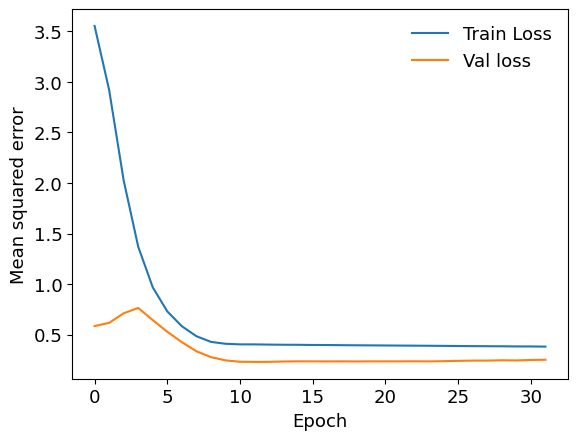

In [ ]:
plot_history(fitted_collector[-1])